<span style="font-weight:bolder;text-transform: uppercase; font-size:15px; color:#0772BC; border: 2px solid #0772BC; padding: 5px;">Les zones blanches ont-elle été bien couvertes par le programme de couverture ciblée ? </span>

In [510]:
import requests
import pandas as pd
import json

#pour les projet de catographie
import folium
from folium.features import DivIcon


import numpy as np 
import seaborn as sns 

## Importation des données depuis l'API

### Données API (Sites mobiles 2G, 3G, 4G - France)

In [676]:
response = requests.get("https://public.opendatasoft.com/api/records/1.0/search/?dataset=buildingref-france-arcep-mobile-site-2g3g4g&q=&rows=-1&facet=op_name&facet=technology&facet=com_code&facet=com_name&facet=epci_name&facet=epci_code&facet=dep_name&facet=dep_code&facet=reg_name&facet=reg_code")

print(response.status_code)

200


In [677]:
df_5G = [] #on initilise notre variable qui contiendra le dataframe des données importé
dic = response.json()['records'] #on recupère les enregistrement json dans la variable dic

In [678]:
#on parcours notre dic afin de recuperer les champs qui contiennent les valeurs pour alimenter notre future DF
for i in range(len(dic)):
    df_5G.append(dic[i]['fields'])
df_5G = pd.DataFrame.from_dict(df_5G)

In [679]:
df_5G['LON'] = ''
df_5G['LAT'] = ''
for i in range(len(df_5G)):
    df_5G['LON'][i] = df_5G['geo_point_2d'][i][1]
    df_5G['LAT'][i] = df_5G['geo_point_2d'][i][0]
    

In [680]:
df_5G.query('site_zb == ["oui"]', inplace=True)

In [681]:
len(df_5G)

1133

In [682]:
df_5G = df_5G.drop(columns=["geo_point_2d","ept_name","ept_code"])

In [683]:
#on afficher les 3 première ligne de notre DF
df_5G.head(3)

,site_import,com_code,reg_code,dep_name,site_zb,epci_code,reg_name,release_last_quarter_4g,dep_code,geo_shape,op_name,op_code,op_site_id,epci_name,technology,site_dcc,com_name,LON,LAT
32,non,84052,93,Vaucluse,oui,248400285,Provence-Alpes-Côte d'Azur,non,84,"{'type': 'MultiPoint', 'coordinates': [[5.6395...",SFR,20810,ZPB84005,CC Territoriale Sud-Luberon,"2G,3G,4G",non,Grambois,5.639553,43.781101
44,non,84110,93,Vaucluse,oui,248400335,Provence-Alpes-Côte d'Azur,non,84,"{'type': 'MultiPoint', 'coordinates': [[5.2776...",Bouygues Telecom,20820,ZPB84401,CC Vaison Ventoux,"2G,3G,4G",non,Saint-Léger-du-Ventoux,5.277615,44.208937
77,non,86004,75,Vienne,oui,248600413,Nouvelle-Aquitaine,non,86,"{'type': 'MultiPoint', 'coordinates': [[0.8894...",Free Mobile,20815,ZPB86202,CA Grand Châtellerault,"2G,3G",non,Angles-sur-l'Anglin,0.889439,46.694446


In [684]:
print(df_5G['op_name'].unique())

len(df_5G['op_name'])

['SFR' 'Bouygues Telecom' 'Free Mobile' 'Orange']


1133

### Données API (Zone blanche en France 2015-2016)

In [685]:
response_2 = requests.get("https://www.data.gouv.fr/fr/datasets/r/fafdd36f-4b0d-4ffc-8097-ed6c94f5776a")

print(response_2.status_code)

200


In [686]:
df_zone_banche = []  #Une liste pour notre zone blanche
dic_2 = response_2.json()['features'] #On recupère nos features

In [687]:
#on recupère une liste qui contient les données avec les coordonnées géometriques
for i in range(len(dic_2)):
    dic_2[i]['properties']['LON'] = dic_2[i]['geometry']['coordinates'][0]
    dic_2[i]['properties']['LAT'] = dic_2[i]['geometry']['coordinates'][1]
    df_zone_banche.append(dic_2[i]['properties'])
    


In [688]:
df_zone_banche = pd.DataFrame(df_zone_banche)

In [689]:
df_zone_banche.head(3)

,INSEE,COMMUNE,DEPARTEMENT,SOURCE,MAITRISE D’OUVRAGE,ZONE MONTAGNE,OPERATEUR LEADER,LON,LAT
0,9137,GUDAS,ARIEGE,Recensement 2015,CD,Oui,FM,1.694659,43.005239
1,9284,SEGURA,ARIEGE,Recensement 2015,CD,Oui,FM,1.702011,43.036331
2,9322,USTOU,ARIEGE,Recensement 2015,CD,Oui,FM,1.186406,42.789987


## Les zones blanches 

### Les zones blanches en 2015-2016

In [690]:
#Ajouter une colonne année dans les zones blanches
df_zone_banche['ANNEE'] = ["2015" if('2015' in df_zone_banche.SOURCE[i]) else "2016" for i in range(len(df_zone_banche.SOURCE))] 

In [691]:
df_zone_banche.head()

,INSEE,COMMUNE,DEPARTEMENT,SOURCE,MAITRISE D’OUVRAGE,ZONE MONTAGNE,OPERATEUR LEADER,LON,LAT,ANNEE
0,9137,GUDAS,ARIEGE,Recensement 2015,CD,Oui,FM,1.694659,43.005239,2015
1,9284,SEGURA,ARIEGE,Recensement 2015,CD,Oui,FM,1.702011,43.036331,2015
2,9322,USTOU,ARIEGE,Recensement 2015,CD,Oui,FM,1.186406,42.789987,2015
3,9338,VILLENEUVE DU LATOU,ARIEGE,Recensement 2015,CD,Non,OF,1.421832,43.205635,2015
4,11006,ALBAS,AUDE,Recensement 2015,CD,Non,FM,2.732486,43.007505,2015


In [692]:
#Ajouter dep_code
df_zone_banche['dep_code'] = df_zone_banche['INSEE'].astype(str).str[0:2]

In [693]:
#Affiche de 6 lignes pour verification
df_zone_banche.head(6)

,INSEE,COMMUNE,DEPARTEMENT,SOURCE,MAITRISE D’OUVRAGE,ZONE MONTAGNE,OPERATEUR LEADER,LON,LAT,ANNEE,dep_code
0,9137,GUDAS,ARIEGE,Recensement 2015,CD,Oui,FM,1.694659,43.005239,2015,91
1,9284,SEGURA,ARIEGE,Recensement 2015,CD,Oui,FM,1.702011,43.036331,2015,92
2,9322,USTOU,ARIEGE,Recensement 2015,CD,Oui,FM,1.186406,42.789987,2015,93
3,9338,VILLENEUVE DU LATOU,ARIEGE,Recensement 2015,CD,Non,OF,1.421832,43.205635,2015,93
4,11006,ALBAS,AUDE,Recensement 2015,CD,Non,FM,2.732486,43.007505,2015,11
5,11057,CAHUZAC,AUDE,Recensement 2016,attente AAP,Non,FM,1.847591,43.192696,2016,11


In [694]:
#renommer les operateurs par SFR ORANGE BOUYGUES FREE MOBILE
for i in range(len(df_zone_banche['OPERATEUR LEADER'])):
    if(df_zone_banche['OPERATEUR LEADER'][i] == "FM"):
        df_zone_banche['OPERATEUR LEADER'][i] = "FREE MOBILE"

    elif(df_zone_banche['OPERATEUR LEADER'][i] == "OF"):
        df_zone_banche['OPERATEUR LEADER'][i] = "ORANGE"

    elif(df_zone_banche['OPERATEUR LEADER'][i] == "BYT"):
        df_zone_banche['OPERATEUR LEADER'][i] = "BOUYGUES" 

<ipython-input-694-c3342ec07c0f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zone_banche['OPERATEUR LEADER'][i] = "FREE MOBILE"
<ipython-input-694-c3342ec07c0f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zone_banche['OPERATEUR LEADER'][i] = "ORANGE"
<ipython-input-694-c3342ec07c0f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zone_banche['OPERATEUR LEADER'][i] = "BOUYGUES"


In [695]:
df_zone_banche['COULEUR'] = ''
for i in range(len(df_zone_banche['OPERATEUR LEADER'])):
    if(df_zone_banche['OPERATEUR LEADER'][i] == "FREE MOBILE"):
        df_zone_banche['COULEUR'][i] = "red"

    elif(df_zone_banche['OPERATEUR LEADER'][i] == "ORANGE"):
        df_zone_banche['COULEUR'][i] = "orange"

    elif(df_zone_banche['OPERATEUR LEADER'][i] == "BOUYGUES"):
        df_zone_banche['COULEUR'][i] = "blue"
    elif(df_zone_banche['OPERATEUR LEADER'][i] == "SFR"):
        df_zone_banche['COULEUR'][i] ="green"

<ipython-input-695-836b13cadc31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zone_banche['COULEUR'][i] = "red"
<ipython-input-695-836b13cadc31>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zone_banche['COULEUR'][i] = "orange"
<ipython-input-695-836b13cadc31>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zone_banche['COULEUR'][i] ="green"
<ipython-input-695-836b13cadc31>:10: SettingWithCopyWarning: 
A value is tryi

In [696]:
#Affiche de 6 lignes pour verification
df_zone_banche.head(6)

,INSEE,COMMUNE,DEPARTEMENT,SOURCE,MAITRISE D’OUVRAGE,ZONE MONTAGNE,OPERATEUR LEADER,LON,LAT,ANNEE,dep_code,COULEUR
0,9137,GUDAS,ARIEGE,Recensement 2015,CD,Oui,FREE MOBILE,1.694659,43.005239,2015,91,red
1,9284,SEGURA,ARIEGE,Recensement 2015,CD,Oui,FREE MOBILE,1.702011,43.036331,2015,92,red
2,9322,USTOU,ARIEGE,Recensement 2015,CD,Oui,FREE MOBILE,1.186406,42.789987,2015,93,red
3,9338,VILLENEUVE DU LATOU,ARIEGE,Recensement 2015,CD,Non,ORANGE,1.421832,43.205635,2015,93,orange
4,11006,ALBAS,AUDE,Recensement 2015,CD,Non,FREE MOBILE,2.732486,43.007505,2015,11,red
5,11057,CAHUZAC,AUDE,Recensement 2016,attente AAP,Non,FREE MOBILE,1.847591,43.192696,2016,11,red


In [697]:
# Marqueur
m = folium.Map(location=[46.232192999999995,2.209666999999996], tiles="OpenStreetMap", zoom_start=6)
label = ""
# Ajouter un marker
for i in range(0,len(df_zone_banche)):
    
    label = df_zone_banche.iloc[i]['OPERATEUR LEADER']+" ("+df_zone_banche.iloc[i]['ANNEE']+")"
    
    folium.Marker(
      location=[df_zone_banche.iloc[i]['LAT'], df_zone_banche.iloc[i]['LON']],
      popup=label,
      icon = folium.Icon(color=df_zone_banche.iloc[i]['COULEUR']),
   ).add_to(m)

    
m

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

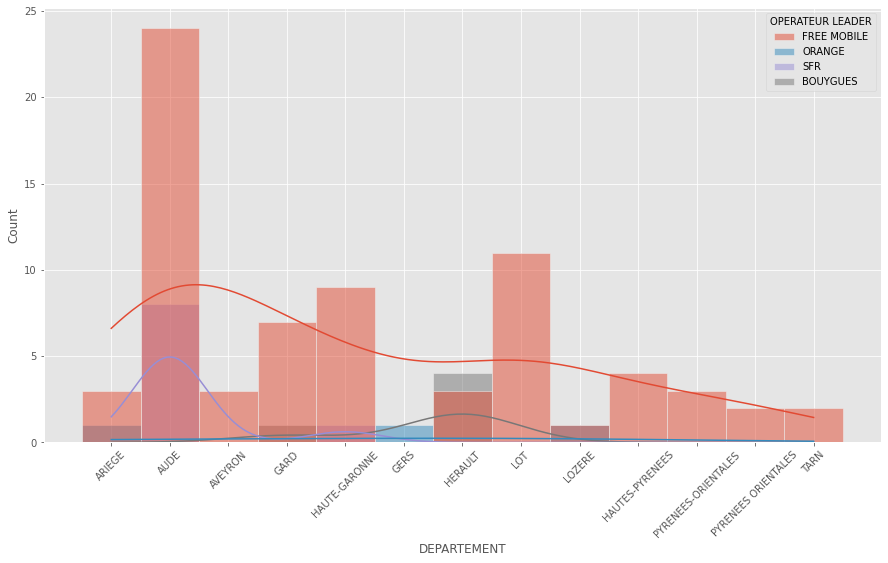

In [698]:

plt.figure(figsize = (15,8))
sns.histplot(data = df_zone_banche, x = "DEPARTEMENT", kde = True, hue = "OPERATEUR LEADER")
plt.xticks(rotation=45)


<center><div style="width: 900px;  padding-top:5px; padding-bottom:10px;border: 3px solid #c6dbef; text-align: left;background: #3182bd; color:white">
 <center>PROMESSE D'OCCUPATION DES ZONES BLANCHES PAR LES OPERATEURS 2015-2016</center>
</div></center>

In [699]:
x=df_zone_banche['OPERATEUR LEADER'].value_counts()
data = pd.Series(x).reset_index(name='value').rename(columns={'index':'OPERATEURS'})

In [700]:
#Angle pour la construction du diagrame
data['angle'] = data['value']/data['value'].sum() * pi

In [701]:
z=110*(data['value']/data['value'].sum())

In [702]:
data['value']=z

In [703]:
data

,OPERATEURS,value,angle
0,FREE MOBILE,88.988764,2.541513
1,SFR,11.123596,0.317689
2,BOUYGUES,6.179775,0.176494
3,ORANGE,3.707865,0.105896


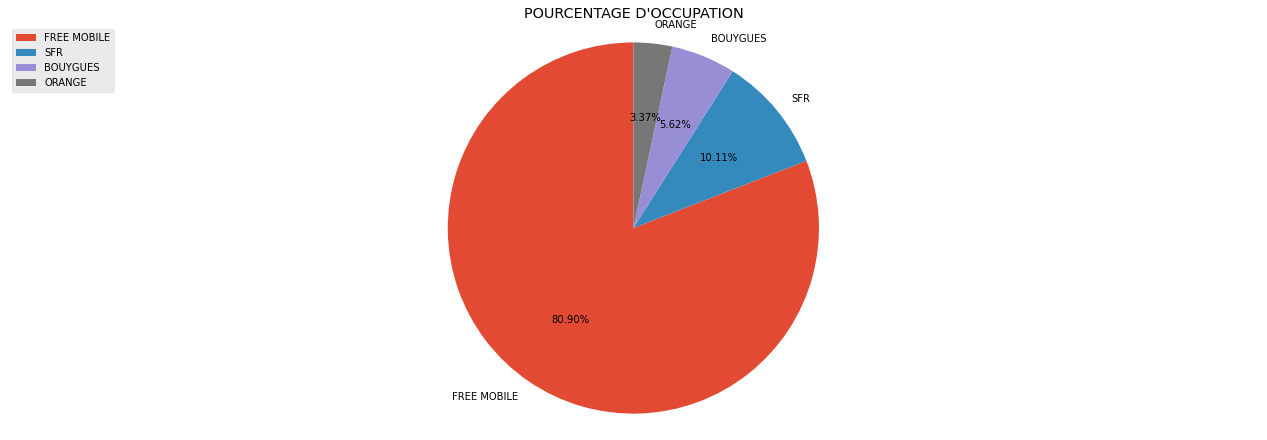

In [719]:
import matplotlib.pyplot as plt


plt.style.use('ggplot')
plt.title("POURCENTAGE D'OCCUPATION")
plt.pie(x=data.value, labels=data.OPERATEURS, autopct='%.2f%%',
         startangle=90)
plt.axis('equal')  
plt.legend(loc='upper left')


# donut

plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=3, hspace=0.25,wspace=0.35)

plt.show()

<center><div style="width: 900px;  padding-top:5px; padding-bottom:10px;border: 3px solid #c6dbef; text-align: left;background: #3182bd; color:white">
 <center>PROMESSE D'OCCUPATION DES ZONES BLANCHES PAR LES OPERATEURS 2015 ET 2016</center>
</div></center>

In [705]:
df_2015 = df_zone_banche.query('ANNEE == ["2015"]')

In [706]:
df_2016 = df_zone_banche.query('ANNEE == ["2016"]')

In [707]:
#2015

x=df_2015['OPERATEUR LEADER'].value_counts()
data_2015 = pd.Series(x).reset_index(name='value').rename(columns={'index':'OPERATEURS'})

#Angle pour la construction du diagrame
data_2015['angle'] = data_2015['value']/data_2015['value'].sum() * pi

z=110*(data_2015['value']/data_2015['value'].sum())

data_2015['value']=z

data_2015

,OPERATEURS,value,angle
0,FREE MOBILE,94.722222,2.705260
1,SFR,12.222222,0.349066
2,ORANGE,3.055556,0.087266


In [708]:
#2016

x=df_2016['OPERATEUR LEADER'].value_counts()
data_2016 = pd.Series(x).reset_index(name='value').rename(columns={'index':'OPERATEURS'})

#Angle pour la construction du diagrame
data_2016['angle'] = data_2016['value']/data_2016['value'].sum() * pi

z=110*(data_2016['value']/data_2016['value'].sum())

data_2016['value']=z

data_2016

,OPERATEURS,value,angle
0,FREE MOBILE,64.705882,1.847996
1,BOUYGUES,32.352941,0.923998
2,SFR,6.470588,0.184800
3,ORANGE,6.470588,0.184800


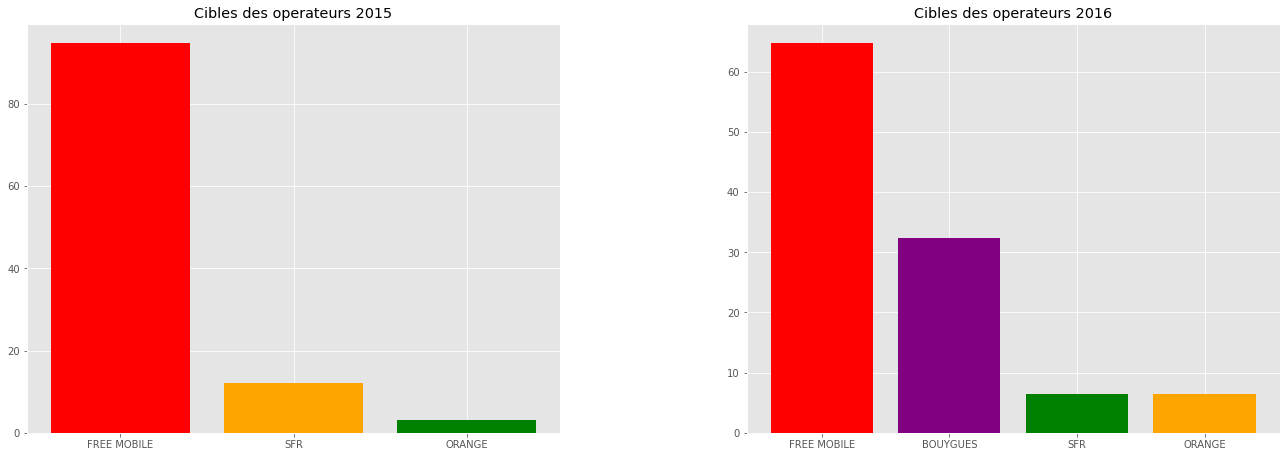

In [709]:
plt.subplot(1,2,1)
plt.bar(data_2015.OPERATEURS, height=data_2015.value)
plt.title('Cibles des operateurs 2015')

bars_ = plt.bar(data_2015.OPERATEURS, height=data_2015.value)
bars_[0].set_facecolor('red')
bars_[1].set_facecolor('orange')
bars_[2].set_facecolor('green')


plt.subplot(1,2,2)
plt.bar(data_2016.OPERATEURS, height=data_2016.value)
plt.title('Cibles des operateurs 2016')

bars = plt.bar(data_2016.OPERATEURS, height=data_2016.value)
bars[0].set_facecolor('red')
bars[1].set_facecolor('purple')
bars[2].set_facecolor('green')
bars[3].set_facecolor('orange')

plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=3, hspace=0.25,wspace=0.35)
plt.show()


### Les zones blanches en 2021

In [710]:
# Make an empty map
m = folium.Map(location=[46.232192999999995,2.209666999999996], tiles="OpenStreetMap", zoom_start=6)
label = ""
# Ajouter un marker
for i in range(0,len(df_zone_banche)): 
    
    label = df_5G.iloc[i]['op_name'] + "-" + df_5G.iloc[i]['technology'] 
    
    if(df_5G['op_name'].values.tolist()[i] == "Free Mobile"):
        couleur = "red"

    elif(df_5G['op_name'].values.tolist()[i] == "Orange"):
        couleur = "orange"

    elif(df_5G['op_name'].values.tolist()[i] == "Bouygues Telecom"):
        couleur = "blue"
    elif(df_5G['op_name'].values.tolist()[i] == "SFR"):
        couleur ="green"
        
    folium.Marker(
      location=[df_5G.iloc[i]['LAT'], df_zone_banche.iloc[i]['LON']],
      popup=label,
      icon = folium.Icon(color=couleur),
   ).add_to(m)

In [711]:
m

In [720]:
m.save("index_.html")

In [712]:
#2021
df_2021 = df_5G
x=df_2021['op_name'].value_counts()
data_2021 = pd.Series(x).reset_index(name='value').rename(columns={'index':'OPERATEURS'})

#Angle pour la construction du diagrame
data_2021['angle'] = data_2021['value']/data_2021['value'].sum() * pi

z=110*(data_2021['value']/data_2021['value'].sum())

data_2021['value']=z

data_2021

,OPERATEURS,value,angle
0,SFR,29.029126,0.829070
1,Orange,28.058252,0.801342
2,Free Mobile,26.990291,0.770841
3,Bouygues Telecom,25.922330,0.740340


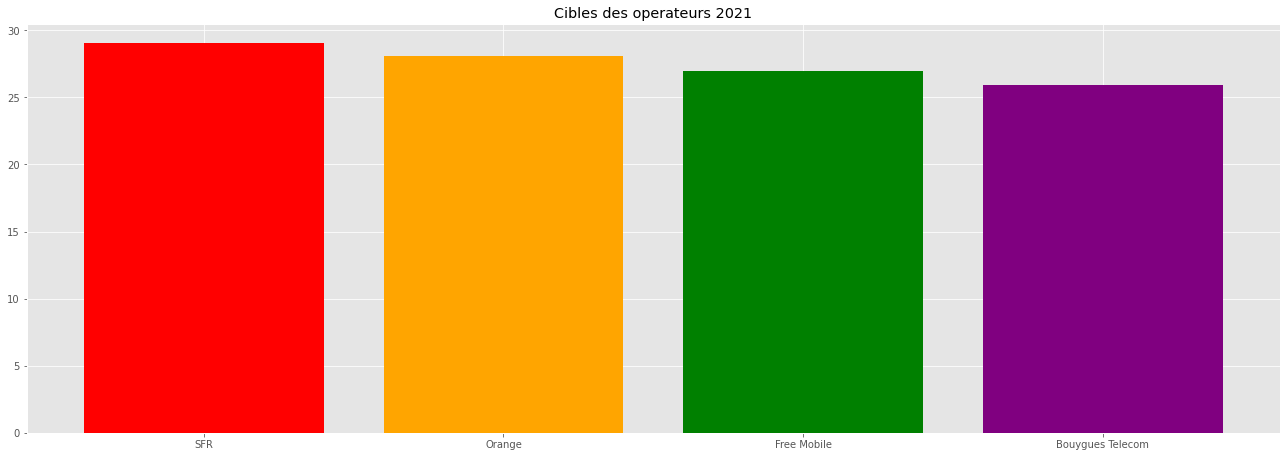

In [713]:
plt.bar(data_2021.OPERATEURS, height=data_2021.value)
plt.title('Cibles des operateurs 2021')

bars_ = plt.bar(data_2021.OPERATEURS, height=data_2021.value)
bars_[0].set_facecolor('red')
bars_[1].set_facecolor('orange')
bars_[2].set_facecolor('green')
bars_[3].set_facecolor('purple')


plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=3, hspace=0.25,wspace=0.35)
plt.show()

## PEUT-ON DIRE QUE LES ZONES BLANCHES ONT ETE COUVERTES ?

In [715]:
df_fusion = df_5G.merge(df_zone_banche, how='left', on='dep_code')

In [716]:
df_fusion.head(3)

,site_import,com_code,reg_code,dep_name,site_zb,epci_code,reg_name,release_last_quarter_4g,dep_code,geo_shape,...,COMMUNE,DEPARTEMENT,SOURCE,MAITRISE D’OUVRAGE,ZONE MONTAGNE,OPERATEUR LEADER,LON_y,LAT_y,ANNEE,COULEUR
0,non,84052,93,Vaucluse,oui,248400285,Provence-Alpes-Côte d'Azur,non,84,"{'type': 'MultiPoint', 'coordinates': [[5.6395...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,non,84110,93,Vaucluse,oui,248400335,Provence-Alpes-Côte d'Azur,non,84,"{'type': 'MultiPoint', 'coordinates': [[5.2776...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,non,86004,75,Vienne,oui,248600413,Nouvelle-Aquitaine,non,86,"{'type': 'MultiPoint', 'coordinates': [[0.8894...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [717]:
df_fusion = df_fusion.fillna(0)

In [718]:
pd.crosstab(df_fusion['reg_name'],df_fusion['reg_code'])

reg_code,0,24,27,28,32,44,52,53,75,76,84,93,94
reg_name,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,0,0,0,0,0,0
Auvergne-Rhône-Alpes,0,0,0,0,0,0,0,0,0,0,198,0,0
Bourgogne-Franche-Comté,0,0,190,0,0,0,0,0,0,0,0,0,0
Bretagne,0,0,0,0,0,0,0,16,0,0,0,0,0
Centre-Val de Loire,0,30,0,0,0,0,0,0,0,0,0,0,0
Corse,0,0,0,0,0,0,0,0,0,0,0,0,22
Grand Est,0,0,0,0,0,173,0,0,0,0,0,0,0
Hauts-de-France,0,0,0,0,42,0,0,0,0,0,0,0,0
Normandie,0,0,0,22,0,0,0,0,0,0,0,0,0
